In [1]:
import numpy as np
from keras.models import Sequential
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation, Input, concatenate, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [15]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
NUMBER_OF_CLASSES = 100
epochs = 200
batch_size = 100
path_best = "gdrive/My Drive/Colab Notebooks/InceptionV2_SGD_NoRegularization.h5"
# path_best = "../weights/InceptionV2_SGD_NoRegularization.h5"
path_train = "gdrive/My Drive/Colab Notebooks/InceptionV2_SGD_NoRegularization_2.h5" 

In [4]:
(x_train,y_train), (x_test, y_test) = cifar100.load_data()

y_train_norm = to_categorical(y_train, NUMBER_OF_CLASSES)
y_test_norm = to_categorical(y_test, NUMBER_OF_CLASSES)

y_test = y_test.flatten()

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))

x_train_norm = (x_train-mean)/(std+1e-7)
x_test_norm = (x_test-mean)/(std+1e-7)

169009152/169001437 [==============================] - 4s 0us/step


In [5]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

datagen.fit(x_train_norm)

In [6]:
def inceptionBuilder(l, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_p):
    l_1 = Conv2D(filters=f_1x1, kernel_size=(1,1), padding='same', activation='relu')(l)

    l_3 = Conv2D(filters=f_3x3_r, kernel_size=(1,1), padding='same', activation='relu')(l)
    l_3 = Conv2D(filters=f_3x3, kernel_size=(3,3), padding='same', activation='relu')(l_3)

    l_5 = Conv2D(filters=f_5x5_r, kernel_size=(1,1), padding='same', activation='relu')(l)
    l_5 = Conv2D(filters=f_5x5, kernel_size=(5,5), padding='same', activation='relu')(l_5)

    l_p = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(l)
    l_p = Conv2D(filters=f_p, kernel_size=(1,1), padding='same', activation='relu')(l_p)

    ret = concatenate([l_1, l_3, l_5, l_p], axis=3)

    return ret

In [7]:
def create_InceptionV2Model():
    input = Input(shape=(32,32,3))
    l = Conv2D(filters=64, kernel_size=(7,7), padding="same")(input)
    l = Activation('relu')(l)
    
    l = MaxPool2D(pool_size=(3,3), padding='same', strides=(2,2))(l)
    l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
    l = Conv2D(filters=192, kernel_size=(3,3), activation='relu')(l)
    l = MaxPool2D(pool_size=(3,3), padding='same', strides=(2,2))(l)

    l = inceptionBuilder(l, 64, 96, 128, 16, 32, 32)
    l = inceptionBuilder(l, 128, 128, 192, 32, 96, 64)

    l = MaxPool2D(pool_size=(3,3,), strides=(2,2), padding='same')(l)

    l = inceptionBuilder(l, 192, 96, 208, 16, 48, 64)

    l = GlobalAveragePooling2D()(l)
    l = Dense(NUMBER_OF_CLASSES, activation='softmax')(l)

    model = Model(inputs = input, outputs = l)
    return model

In [8]:
model = create_InceptionV2Model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           activation[0][0]                 
_______________________________________________________________________________________

In [9]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

**Training**

In [10]:
checkpoint = ModelCheckpoint(path_train, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [11]:
history = model.fit(datagen.flow(x_train_norm, y_train_norm,
                                        batch_size=batch_size),
                        steps_per_epoch=x_train_norm.shape[0]// batch_size,
                        epochs=epochs,
                        validation_data=(x_test_norm,y_test_norm),
                        callbacks=[checkpoint, early],verbose=2)

Epoch 1/200

Epoch 00001: val_accuracy improved from -inf to 0.11560, saving model to gdrive/My Drive/Colab Notebooks/InceptionV2_SGD_NoRegularization_2.h5
500/500 - 23s - loss: 4.2439 - accuracy: 0.0561 - val_loss: 3.8101 - val_accuracy: 0.1156
Epoch 2/200

Epoch 00002: val_accuracy improved from 0.11560 to 0.19870, saving model to gdrive/My Drive/Colab Notebooks/InceptionV2_SGD_NoRegularization_2.h5
500/500 - 23s - loss: 3.5710 - accuracy: 0.1526 - val_loss: 3.3460 - val_accuracy: 0.1987
Epoch 3/200

Epoch 00003: val_accuracy improved from 0.19870 to 0.26620, saving model to gdrive/My Drive/Colab Notebooks/InceptionV2_SGD_NoRegularization_2.h5
500/500 - 23s - loss: 3.1587 - accuracy: 0.2222 - val_loss: 2.9397 - val_accuracy: 0.2662
Epoch 4/200

Epoch 00004: val_accuracy improved from 0.26620 to 0.30360, saving model to gdrive/My Drive/Colab Notebooks/InceptionV2_SGD_NoRegularization_2.h5
500/500 - 23s - loss: 2.8430 - accuracy: 0.2818 - val_loss: 2.7255 - val_accuracy: 0.3036
Epoch 5

*Plotting training accuracy and loss*

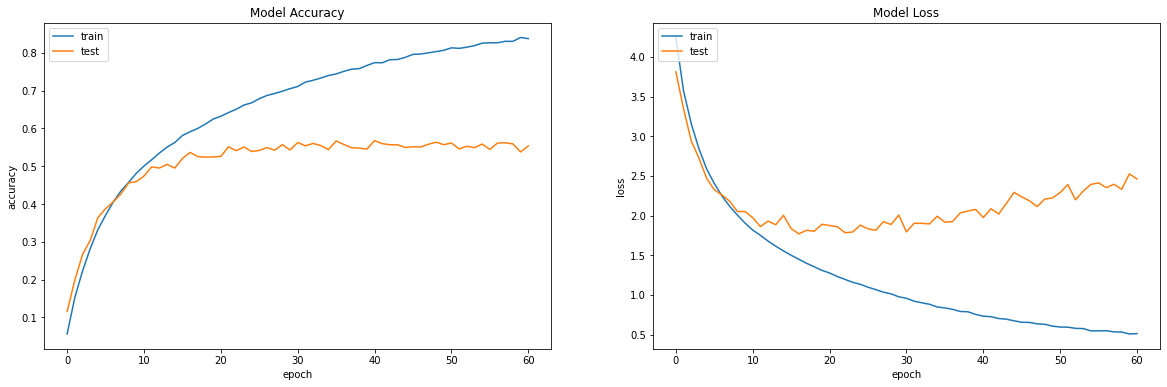

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set(ylabel ='accuracy')
axs[0].set(xlabel ='epoch')
axs[0].legend(['train', 'test'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set(ylabel='loss')
axs[1].set(xlabel='epoch')
axs[1].legend(['train', 'test'], loc='upper left')

**Prediction**

In [16]:
model.load_weights(path_best) 
y_pred = np.argmax(model.predict(x_test_norm), axis=-1)

In [17]:
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision: ", precision)
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall: ", recall)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Precision:  0.5060049055955125
Recall:  0.4998
Accuracy:  0.4998
